Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [10]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():
  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  tf_reg = tf.placeholder(tf.float32)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = (tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + 
    tf_reg*tf.nn.l2_loss(weights))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [20]:
num_steps = 3001
reg_set = np.logspace(-3.5, -2, 40)
valid_acc_track = []

with tf.Session(graph=graph) as session:
    for reg in reg_set:
      tf.global_variables_initializer().run()
      #print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_reg : reg}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
      print("Regularized valid accuracy: %.1f%% when reg paramer equals %.5f" %
           (accuracy(valid_prediction.eval(), valid_labels), reg))
      #print("Regularized test accuracy: %.1f%% when reg paramer equals %.5f" %
      #     (accuracy(test_prediction.eval(), test_labels), reg))
        
      valid_acc_track.append(accuracy(valid_prediction.eval(), valid_labels))    

Regularized valid accuracy: 80.4% when reg paramer equals 0.00032
Regularized valid accuracy: 80.8% when reg paramer equals 0.00035
Regularized valid accuracy: 80.8% when reg paramer equals 0.00038
Regularized valid accuracy: 80.7% when reg paramer equals 0.00041
Regularized valid accuracy: 81.0% when reg paramer equals 0.00045
Regularized valid accuracy: 81.2% when reg paramer equals 0.00049
Regularized valid accuracy: 81.0% when reg paramer equals 0.00054
Regularized valid accuracy: 81.5% when reg paramer equals 0.00059
Regularized valid accuracy: 81.7% when reg paramer equals 0.00064
Regularized valid accuracy: 81.4% when reg paramer equals 0.00070
Regularized valid accuracy: 81.8% when reg paramer equals 0.00077
Regularized valid accuracy: 81.7% when reg paramer equals 0.00084
Regularized valid accuracy: 81.9% when reg paramer equals 0.00092
Regularized valid accuracy: 81.8% when reg paramer equals 0.00100
Regularized valid accuracy: 81.9% when reg paramer equals 0.00109
Regularize

Best beta=0.00143, accuracy=82.1%


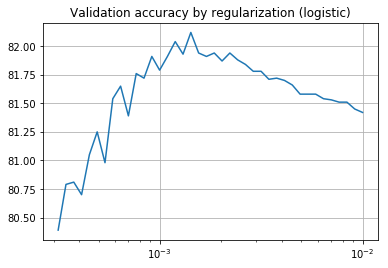

In [22]:
import matplotlib.pyplot as plt

print('Best beta=%.5f, accuracy=%.1f%%' % (reg_set[np.argmax(valid_acc_track)], max(valid_acc_track)))
plt.semilogx(reg_set, valid_acc_track)
plt.grid(True)
plt.title('Validation accuracy by regularization (logistic)')
plt.show()

Train model with the best regularization parameter:

In [21]:
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  #print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, 
                 tf_reg : reg_set[np.argmax(valid_acc_track)]}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
  print("Regularized test accuracy: %.1f%% when reg paramer equals %.5f" %
        (accuracy(test_prediction.eval(), test_labels), 
         reg_set[np.argmax(valid_acc_track)]))

Regularized test accuracy: 89.2% when reg paramer equals 0.00143


Let's now try one hidden layer:

In [23]:
batch_size = 128
hidden_size = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_reg = tf.placeholder(tf.float32)

    # Variables for hidden layer.
    W1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_size]))
    b1 = tf.Variable(tf.zeros([hidden_size]))

    # Variables for output layer.
    W2 = tf.Variable(tf.truncated_normal([hidden_size, num_labels]))
    b2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    z1 = tf.matmul(tf_train_dataset, W1) + b1
    h1 = tf.nn.relu(z1)
    logits = tf.matmul(h1, W2) + b2

    loss = (tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) +
            tf_reg*tf.nn.l2_loss(W1) + tf_reg*tf.nn.l2_loss(W2))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)

    z1_valid = tf.matmul(tf_valid_dataset, W1) + b1
    h1_valid = tf.nn.relu(z1_valid)
    valid_logits = tf.matmul(h1_valid, W2) + b2
    valid_prediction = tf.nn.softmax(valid_logits)

    z1_test = tf.matmul(tf_test_dataset, W1) + b1
    h1_test = tf.nn.relu(z1_test)
    test_logits = tf.matmul(h1_test, W2) + b2
    test_prediction = tf.nn.softmax(test_logits)

In [24]:
num_steps = 3001
reg_set = np.logspace(-4, -2, 40)
valid_acc_track = []

with tf.Session(graph=graph) as session:
    for reg in reg_set:
      tf.global_variables_initializer().run()
      #print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_reg : reg}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
      print("Regularized valid accuracy: %.1f%% when reg paramer equals %.5f" %
           (accuracy(valid_prediction.eval(), valid_labels), reg))
      #print("Regularized test accuracy: %.1f%% when reg paramer equals %.5f" %
      #     (accuracy(test_prediction.eval(), test_labels), reg))
        
      valid_acc_track.append(accuracy(valid_prediction.eval(), valid_labels))    

Regularized valid accuracy: 82.5% when reg paramer equals 0.00010
Regularized valid accuracy: 82.7% when reg paramer equals 0.00011
Regularized valid accuracy: 82.6% when reg paramer equals 0.00013
Regularized valid accuracy: 83.0% when reg paramer equals 0.00014
Regularized valid accuracy: 82.8% when reg paramer equals 0.00016
Regularized valid accuracy: 82.6% when reg paramer equals 0.00018
Regularized valid accuracy: 82.1% when reg paramer equals 0.00020
Regularized valid accuracy: 82.7% when reg paramer equals 0.00023
Regularized valid accuracy: 83.3% when reg paramer equals 0.00026
Regularized valid accuracy: 83.7% when reg paramer equals 0.00029
Regularized valid accuracy: 83.3% when reg paramer equals 0.00033
Regularized valid accuracy: 83.8% when reg paramer equals 0.00037
Regularized valid accuracy: 84.6% when reg paramer equals 0.00041
Regularized valid accuracy: 84.6% when reg paramer equals 0.00046
Regularized valid accuracy: 84.5% when reg paramer equals 0.00052
Regularize

Best beta=0.00119, accuracy=87.0%


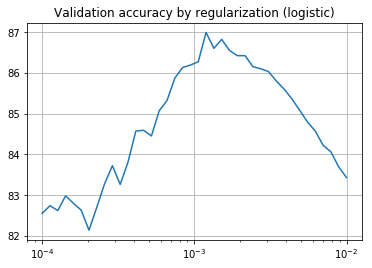

In [25]:
import matplotlib.pyplot as plt

print('Best beta=%.5f, accuracy=%.1f%%' % (reg_set[np.argmax(valid_acc_track)], max(valid_acc_track)))
plt.semilogx(reg_set, valid_acc_track)
plt.grid(True)
plt.title('Validation accuracy by regularization (logistic)')
plt.show()

In [26]:
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  #print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, 
                 tf_reg : reg_set[np.argmax(valid_acc_track)]}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
  print("Regularized test accuracy: %.1f%% when reg paramer equals %.5f" %
        (accuracy(test_prediction.eval(), test_labels), 
         reg_set[np.argmax(valid_acc_track)]))

Regularized test accuracy: 93.3% when reg paramer equals 0.00119


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [28]:
few_batch_size = batch_size * 5
small_train_dataset = train_dataset[:few_batch_size, :]
small_train_labels = train_labels[:few_batch_size, :]
print('Training set', small_train_dataset.shape, small_train_labels.shape)

num_steps = 3001
reg_set = np.logspace(-4, -2, 20)
valid_acc_track = []

with tf.Session(graph=graph, config=tf.ConfigProto(log_device_placement=True)) as session:
    for reg in reg_set:
      tf.global_variables_initializer().run()
      #print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (small_train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = small_train_dataset[offset:(offset + batch_size), :]
        batch_labels = small_train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_reg : reg}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
      print("Regularized valid accuracy: %.1f%% when reg paramer equals %.5f" %
           (accuracy(valid_prediction.eval(), valid_labels), reg))
      #print("Regularized test accuracy: %.1f%% when reg paramer equals %.5f" %
      #     (accuracy(test_prediction.eval(), test_labels), reg))
        
      valid_acc_track.append(accuracy(valid_prediction.eval(), valid_labels))    

Training set (640, 784) (640, 10)
Regularized valid accuracy: 75.3% when reg paramer equals 0.00010
Regularized valid accuracy: 76.3% when reg paramer equals 0.00013
Regularized valid accuracy: 76.2% when reg paramer equals 0.00016
Regularized valid accuracy: 75.5% when reg paramer equals 0.00021
Regularized valid accuracy: 75.8% when reg paramer equals 0.00026
Regularized valid accuracy: 75.6% when reg paramer equals 0.00034
Regularized valid accuracy: 75.7% when reg paramer equals 0.00043
Regularized valid accuracy: 75.9% when reg paramer equals 0.00055
Regularized valid accuracy: 75.3% when reg paramer equals 0.00070
Regularized valid accuracy: 76.6% when reg paramer equals 0.00089
Regularized valid accuracy: 75.5% when reg paramer equals 0.00113
Regularized valid accuracy: 77.6% when reg paramer equals 0.00144
Regularized valid accuracy: 79.3% when reg paramer equals 0.00183
Regularized valid accuracy: 79.6% when reg paramer equals 0.00234
Regularized valid accuracy: 79.7% when reg

Best beta=0.00379, accuracy=79.9%


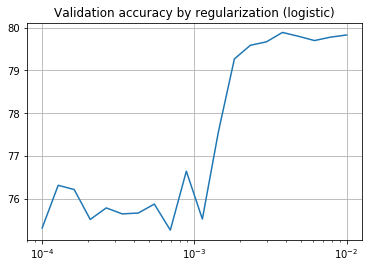

In [29]:
import matplotlib.pyplot as plt

print('Best beta=%.5f, accuracy=%.1f%%' % (reg_set[np.argmax(valid_acc_track)], max(valid_acc_track)))
plt.semilogx(reg_set, valid_acc_track)
plt.grid(True)
plt.title('Validation accuracy by regularization (logistic)')
plt.show()

In [30]:
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  #print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (small_train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = small_train_dataset[offset:(offset + batch_size), :]
    batch_labels = small_train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, 
                 tf_reg : reg_set[np.argmax(valid_acc_track)]}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
  print("Regularized test accuracy: %.1f%% when reg paramer equals %.5f" %
        (accuracy(test_prediction.eval(), test_labels), 
         reg_set[np.argmax(valid_acc_track)]))

Regularized test accuracy: 86.6% when reg paramer equals 0.00379


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [33]:
batch_size = 128
hidden_size = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_reg = tf.placeholder(tf.float32)

    # Variables for hidden layer.
    W1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_size]))
    b1 = tf.Variable(tf.zeros([hidden_size]))

    # Variables for output layer.
    W2 = tf.Variable(tf.truncated_normal([hidden_size, num_labels]))
    b2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    z1 = tf.matmul(tf_train_dataset, W1) + b1
    h1 = tf.nn.relu(z1)
    h1 = tf.nn.dropout(h1, keep_prob=0.5)
    logits = tf.matmul(h1, W2) + b2

    loss = (tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) +
            tf_reg*tf.nn.l2_loss(W1) + tf_reg*tf.nn.l2_loss(W2))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)

    z1_valid = tf.matmul(tf_valid_dataset, W1) + b1
    h1_valid = tf.nn.relu(z1_valid)
    valid_logits = tf.matmul(h1_valid, W2) + b2
    valid_prediction = tf.nn.softmax(valid_logits)

    z1_test = tf.matmul(tf_test_dataset, W1) + b1
    h1_test = tf.nn.relu(z1_test)
    test_logits = tf.matmul(h1_test, W2) + b2
    test_prediction = tf.nn.softmax(test_logits)

In [34]:
num_steps = 3001
reg_set = np.logspace(-4, -2, 20)
valid_acc_track = []

with tf.Session(graph=graph) as session:
    for reg in reg_set:
      tf.global_variables_initializer().run()
      #print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_reg : reg}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
      print("Regularized valid accuracy: %.1f%% when reg paramer equals %.5f" %
           (accuracy(valid_prediction.eval(), valid_labels), reg))
      #print("Regularized test accuracy: %.1f%% when reg paramer equals %.5f" %
      #     (accuracy(test_prediction.eval(), test_labels), reg))
        
      valid_acc_track.append(accuracy(valid_prediction.eval(), valid_labels))    

Regularized valid accuracy: 80.4% when reg paramer equals 0.00010
Regularized valid accuracy: 80.9% when reg paramer equals 0.00013
Regularized valid accuracy: 80.9% when reg paramer equals 0.00016
Regularized valid accuracy: 81.0% when reg paramer equals 0.00021
Regularized valid accuracy: 81.8% when reg paramer equals 0.00026
Regularized valid accuracy: 82.2% when reg paramer equals 0.00034
Regularized valid accuracy: 82.8% when reg paramer equals 0.00043
Regularized valid accuracy: 83.1% when reg paramer equals 0.00055
Regularized valid accuracy: 84.4% when reg paramer equals 0.00070
Regularized valid accuracy: 84.9% when reg paramer equals 0.00089
Regularized valid accuracy: 85.2% when reg paramer equals 0.00113
Regularized valid accuracy: 85.4% when reg paramer equals 0.00144
Regularized valid accuracy: 85.0% when reg paramer equals 0.00183
Regularized valid accuracy: 85.1% when reg paramer equals 0.00234
Regularized valid accuracy: 85.0% when reg paramer equals 0.00298
Regularize

Best beta=0.00144, accuracy=85.4%


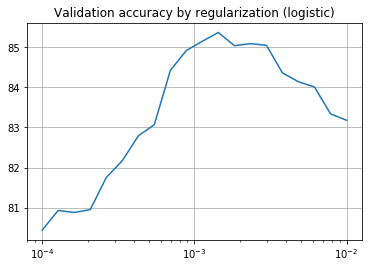

In [35]:
import matplotlib.pyplot as plt

print('Best beta=%.5f, accuracy=%.1f%%' % (reg_set[np.argmax(valid_acc_track)], max(valid_acc_track)))
plt.semilogx(reg_set, valid_acc_track)
plt.grid(True)
plt.title('Validation accuracy by regularization (logistic)')
plt.show()

In [37]:
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  #print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, 
                 tf_reg : reg_set[np.argmax(valid_acc_track)]}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
  print("Regularized test accuracy: %.1f%% when reg paramer equals %.5f" %
        (accuracy(test_prediction.eval(), test_labels), 
         reg_set[np.argmax(valid_acc_track)]))

Regularized test accuracy: 92.2% when reg paramer equals 0.00144


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [46]:
batch_size = 128
hidden_size = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_reg = tf.placeholder(tf.float32)
    
    global_step = tf.Variable(0, trainable=False)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, decay_steps=1000, decay_rate=0.90, 
                                               staircase=True)

    # Variables for hidden layer.
    W1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_size]))
    b1 = tf.Variable(tf.zeros([hidden_size]))

    # Variables for output layer.
    W2 = tf.Variable(tf.truncated_normal([hidden_size, num_labels]))
    b2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    z1 = tf.matmul(tf_train_dataset, W1) + b1
    h1 = tf.nn.relu(z1)
    #h1 = tf.nn.dropout(h1, keep_prob=0.5)
    logits = tf.matmul(h1, W2) + b2

    loss = (tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) +
            tf_reg*tf.nn.l2_loss(W1) + tf_reg*tf.nn.l2_loss(W2))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)

    z1_valid = tf.matmul(tf_valid_dataset, W1) + b1
    h1_valid = tf.nn.relu(z1_valid)
    valid_logits = tf.matmul(h1_valid, W2) + b2
    valid_prediction = tf.nn.softmax(valid_logits)

    z1_test = tf.matmul(tf_test_dataset, W1) + b1
    h1_test = tf.nn.relu(z1_test)
    test_logits = tf.matmul(h1_test, W2) + b2
    test_prediction = tf.nn.softmax(test_logits)

In [47]:
num_steps = 8001
reg_set = np.logspace(-4, -2, 20)
valid_acc_track = []

with tf.Session(graph=graph) as session:
    for reg in reg_set:
      tf.global_variables_initializer().run()
      #print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_reg : reg}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)

      print("Regularized valid accuracy: %.1f%% when reg paramer equals %.5f" %
           (accuracy(valid_prediction.eval(), valid_labels), reg))
      #print("Regularized test accuracy: %.1f%% when reg paramer equals %.5f" %
      #     (accuracy(test_prediction.eval(), test_labels), reg))

      valid_acc_track.append(accuracy(valid_prediction.eval(), valid_labels))    

Regularized valid accuracy: 84.9% when reg paramer equals 0.00010
Regularized valid accuracy: 85.0% when reg paramer equals 0.00013
Regularized valid accuracy: 85.5% when reg paramer equals 0.00016
Regularized valid accuracy: 86.1% when reg paramer equals 0.00021
Regularized valid accuracy: 86.8% when reg paramer equals 0.00026
Regularized valid accuracy: 87.0% when reg paramer equals 0.00034
Regularized valid accuracy: 87.8% when reg paramer equals 0.00043
Regularized valid accuracy: 88.2% when reg paramer equals 0.00055
Regularized valid accuracy: 88.4% when reg paramer equals 0.00070
Regularized valid accuracy: 88.4% when reg paramer equals 0.00089
Regularized valid accuracy: 88.3% when reg paramer equals 0.00113
Regularized valid accuracy: 88.1% when reg paramer equals 0.00144
Regularized valid accuracy: 87.7% when reg paramer equals 0.00183
Regularized valid accuracy: 87.1% when reg paramer equals 0.00234
Regularized valid accuracy: 86.7% when reg paramer equals 0.00298
Regularize

Best beta=0.00089, accuracy=88.4%


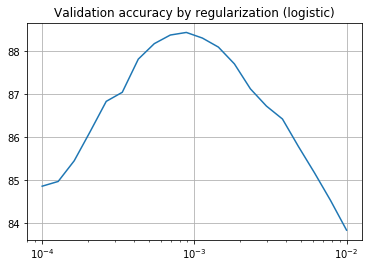

In [48]:
import matplotlib.pyplot as plt

print('Best beta=%.5f, accuracy=%.1f%%' % (reg_set[np.argmax(valid_acc_track)], max(valid_acc_track)))
plt.semilogx(reg_set, valid_acc_track)
plt.grid(True)
plt.title('Validation accuracy by regularization (logistic)')
plt.show()

In [49]:
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  #print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, 
                 tf_reg : reg_set[np.argmax(valid_acc_track)]}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
  print("Regularized test accuracy: %.1f%% when reg paramer equals %.5f" %
        (accuracy(test_prediction.eval(), test_labels), 
         reg_set[np.argmax(valid_acc_track)]))

Regularized test accuracy: 94.5% when reg paramer equals 0.00089
